In [20]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

In [21]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.model

importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd)

from endoutbreakvbd import eop_analytical, eop_simulation
from endoutbreakvbd.chikungunya import get_lazio_2017_data, get_parameters

[Text(5, 0, '1 Jul'),
 Text(36, 0, '1 Aug'),
 Text(67, 0, '1 Sep'),
 Text(97, 0, '1 Oct'),
 Text(128, 0, '1 Nov')]

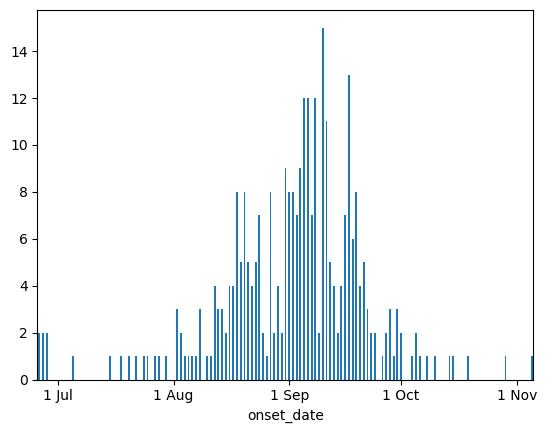

In [ ]:
fig, ax = plt.subplots()
df = get_lazio_2017_data()
df["cases"].plot.bar(ax=ax)

pos = np.arange(len(df))
month_starts = df.index.is_month_start
ax.set_xticks(pos[month_starts])
labels = [f"{d.day} {d:%b}" for d in df.index[month_starts]]
ax.set_xticklabels(labels, rotation=0)